In [1]:
import spot
spot.setup()
from spot.jupyter import display_inline
def display2(*args):
    display_inline(*args, per_row=2)

# Definitions and examples for parity acceptance

In Spot a **parity acceptance** is defined by a **kind**, a **style** and a **numsets**:
+ The **kind** can be either **max** or **min**.
+ The **style** can be either **odd** or **even**.
+ The **numsets** is the number of acceptance sets (a.k.a. colors) used by the parity acceptance.
    
Here are some examples:

In [2]:
for kind in ['min', 'max']:
    for style in ['odd', 'even']:
        for sets in range(1, 5):
            name = 'parity {} {} {}'.format(kind, style, sets)
            print('{:17} = {}'.format(name, spot.acc_code(name)))

parity min odd 1  = Fin(0)
parity min odd 2  = Fin(0) & Inf(1)
parity min odd 3  = Fin(0) & (Inf(1) | Fin(2))
parity min odd 4  = Fin(0) & (Inf(1) | (Fin(2) & Inf(3)))
parity min even 1 = Inf(0)
parity min even 2 = Inf(0) | Fin(1)
parity min even 3 = Inf(0) | (Fin(1) & Inf(2))
parity min even 4 = Inf(0) | (Fin(1) & (Inf(2) | Fin(3)))
parity max odd 1  = Fin(0)
parity max odd 2  = Inf(1) | Fin(0)
parity max odd 3  = Fin(2) & (Inf(1) | Fin(0))
parity max odd 4  = Inf(3) | (Fin(2) & (Inf(1) | Fin(0)))
parity max even 1 = Inf(0)
parity max even 2 = Fin(1) & Inf(0)
parity max even 3 = Inf(2) | (Fin(1) & Inf(0))
parity max even 4 = Fin(3) & (Inf(2) | (Fin(1) & Inf(0)))


Of course the case of parity automata with a single color is a bit degenerate, as the same formula corresponds to two parity conditions of different kinds. 

In addition to the above, an automaton is said to be **colored** if each of its edges (or states) has exactly one color.  Automata that people usually call *parity automata* correspond in Spot to *colored* automata with *parity acceptance*.  For this reason try to use the term *automata with parity acceptance* rather than *parity automata* for automata that are not *colored*.

In [3]:
# Generate a few random automata for the upcoming examples.
maxodd4, maxodd5, minodd4, minodd5, maxeven4 = spot.automata("""
randaut -A 'parity max odd 4' -Q4 -e.4 2;
randaut -A 'parity max odd 5' -Q4 -e.4 2;
randaut -A 'parity min odd 4' -Q4 -e.4 2;
randaut -A 'parity min odd 5' -Q4 -e.4 2;
randaut -A 'parity max even 4' -Q4 -e.4 2|""")

# Testing parity and colored

`is_parity()` is a method of `spot.acc_cond` that returns three Boolean values: 
1. whether the condition is a parity condition,
2. whether it has `max` kind,
3. whether it has `odd` style.

In [4]:
maxodd4.acc().is_parity()

[True, True, True]

In [5]:
maxeven4.acc().is_parity()

[True, True, False]

In [6]:
minodd5.acc().is_parity()

[True, False, True]

By default, `is_parity()` will match only conditions that are exactly equal to what the HOA format defines for the relevant configuration.   For instance, the formula for `min odd 4` should be exactly the following:

In [7]:
print(spot.acc_code("parity min odd 4"))

Fin(0) & (Inf(1) | (Fin(2) & Inf(3)))


However there are many formulas that are equivalent to the above.  For instance the following `testacc` acceptance condition is logically equivalent to `parity min odd 4`.  Passing it through `is_parity()` will fail: the first Boolean returned is False, and the remaining one should be ignored.

In [8]:
testacc = spot.acc_cond("(Fin(0) & Inf(1)) | (Fin(0) & Fin(2) & Inf(3))")
print(testacc.is_parity())

[False, False, True]


To test logical equivalence to a Parity condition, pass a `True` argument to `is_parity()`.

In [9]:
print(testacc.is_parity(True))

[True, False, True]


To test if an automaton is colored, use `is_colored`.  Not this technically, this property is orthogonal to the fact the the automaton uses the acceptance conditions.  It just states that each edge (or state) belongs to exactly one acceptance set.

In [10]:
spot.is_colored(minodd4)

False

In [11]:
spot.is_colored(spot.colorize_parity(minodd4)) # See below for `colorize_parity()`.

True

# Functions for altering automata with parity acceptance

- [`change_parity()`](#Change-parity) can be used to alter the [*style*](#Changing-the-style), or [*kind*](#Changing-the-kind) of a parity acceptance.  For instance if you have an automaton with `parity min even` acceptance and want an automaton with `parity max odd`, this is the function to use.
- [`colorize_parity()`](#Colorize-parity) transforms an automaton with parity acceptance into a colored automaton with parity acceptance (a.k.a., parity automaton).
- [`cleanup_parity()`](#Cleanup-parity) remove from the acceptance condition colors that are unused in the automaton, while keeping it a parity acceptance.
- [`reduce_parity()`](#Reduce-parity) minimize the number of colors used in the automaton, producing the smallest parity acceptance condition possible for this automaton.

# Change parity

This section describes the `change_parity()` method, that allows switching between different kinds and styles.
Its takes three arguments:
1. the automaton to modify
2. the desired kind (`spot.parity_kind_any`, `spot.parity_kind_same`, `spot.parity_kind_max`, `spot.parity_kind_min`)
3. the desired style (`spot.parity_style_any`, `spot.parity_style_same`, `spot.parity_style_odd`, `spot.parity_style_even`)

## Changing the **style**

Changing the style from `odd` to `even` or vice-versa can be done by adding a new color 0 and shifting all original colors by one, keeping the maximum or minimum color in case an edge has multiple colors.

When the acceptance is a parity `max`, all the transitions that do not belong to any acceptance set will have the new color.

### max odd 5 → max even 6

In [12]:
display2(maxodd5, spot.change_parity(maxodd5, spot.parity_kind_any, spot.parity_style_even))

### min odd 5 → min even 6


In [13]:
display2(minodd5, spot.change_parity(minodd5, spot.parity_kind_any, spot.parity_style_even))

## Changing the **kind**

Generaly to go from `parity max` to `parity min`, it suffices to reverse the order of vertices.

### max odd 5 → min odd 5:

In [14]:
display2(maxodd5, spot.change_parity(maxodd5, spot.parity_kind_min, spot.parity_style_any))

###  max odd 4 → min even 4

When the number of colors is even, the style is changed too.

In [15]:
display2(maxodd4, spot.change_parity(maxodd4, spot.parity_kind_min, spot.parity_style_any))

### max odd 4 → min odd 5

In this case, to keep the same **style**, a new color would be introduced.

In [16]:
display2(maxodd4, spot.change_parity(maxodd4, spot.parity_kind_min, spot.parity_style_same))

# Colorize parity

People working with parity automata usually expect all states (or edges) to have exactly one color.  This constraint, which comes in addition to the use of a parity acceptance, is what the HOA format calls "colored".

A *parity automaton* is a *colored* automaton with *parity acceptance*.

Coloring an automaton can be done with the `colorize_parity()` function.  This function is not very smart: it will not attempt to simplify the acceptance before colorizing it.

## Parity max
Transitions with multiple colors are purified by keeping only the set with the greatest index.
<br>
If there are uncolored transitions, they get assigned to color 0, and all original colors are shifted by one, toggling the style.  If the style must be preserved (second argument set to True), we can shift all colors once more.

#### Colorize parity max odd 4

In [17]:
display2(maxodd4, spot.colorize_parity(maxodd4, False))
display2(maxodd4, spot.colorize_parity(maxodd4, True))

#### Colorize parity max even 4

In [18]:
display2(maxeven4, spot.colorize_parity(maxeven4, False))
display2(maxeven4, spot.colorize_parity(maxeven4, True))

## Parity min
Transitions with multiple colors are simplified by keeping only the color with the lowest index.
<br>
An extra color may be introduced at the end of the range, without changing the acceptance style (so the second argument of `colorize_parity()` is useless in this case).

#### Colorize parity min odd 4

In [19]:
display2(minodd4, spot.colorize_parity(minodd4))

## Degenerate cases

### max odd 1

This is just another name for co-Büchi.

In [20]:
maxodd1 = spot.automaton("randaut -A 'parity max odd 1' -Q4 2|")
display2(maxodd1, spot.colorize_parity(maxodd1))

### max even 1

Another name for Büchi

In [21]:
maxeven1 = spot.automaton("randaut -A 'parity max even 1' -Q4 2|")
display2(maxeven1, spot.colorize_parity(maxeven1))

Here `Streett 1` is just a synonym for `parity max odd 2`.  (Spot's automaton printer cannot guess which name should be prefered.)

In [22]:
spot.acc_cond("parity max odd 2").name()

'Streett 1'

# Cleanup parity

The `cleanup_parity()` function removes useless colors of an automaton with parity acceptance.
This function is just looking at colors that do not occur in the automaton to perform the simplification.
For a stronger simplification, see [`reduce_parity()`](#Reduce-parity) below.

In [23]:
display2(minodd4, spot.cleanup_parity(minodd4))
display2(maxodd5, spot.cleanup_parity(maxodd5))
display2(maxodd4, spot.cleanup_parity(maxodd4))

Here Rabin 1, co-Büchi, and Streett 1, are respectively the same as "min odd 2", "max odd 1", "max odd 2".

# Reduce parity

The `reduce_parity()` function is a more elaborate version of `cleanup_parity()`.  It implements an algorithm by Carton and Maceiras (*Computing the Rabin index of a parity automaton*, Informatique théorique et applications, 1999), to obtain the minimal parity acceptance condition for a given automaton.  While the original algorithm assumes *max odd* parity, this version works with the four types of parity acceptance.  It will only try to preserve the kind (max/min) and may change the style if it allows saving one color.  Furthermore, it can colorize (or uncolorize) automata at the same time,
making it a very nice replacement for both `cleanup_parity()` and `colorize_parity()`.

It takes three arguments:
1. the automaton whose parity acceptance condition should be reduced
2. a Boolean indicating whether the output should be colored (`True`), or if transition with no color can be used (`False`).
3. a Boolean indicating whether the output should be layered, i.e., in a max parity automaton, that means the color of a transition should be the maximal color visited by all cycles going through it.

By default, the second argument is `False`, because acceptance sets is a scarse ressource in Spot.  The third argument also defaults to `False`, but for empircal reason: adding more colors like this tends to hinder simulation-based reductions.

In [24]:
display2(minodd4, spot.reduce_parity(minodd4))
display2(minodd4, spot.reduce_parity(minodd4, True))

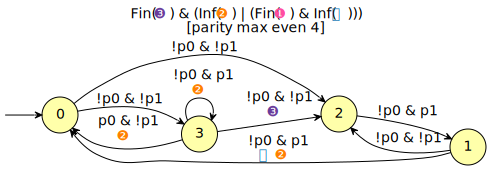

In [25]:
display(maxeven4)
display2(spot.reduce_parity(maxeven4), spot.reduce_parity(maxeven4, True))
display2(spot.reduce_parity(maxeven4, False, True), spot.reduce_parity(maxeven4, True, True))